# Time Series Analysis of Flight Delays

The purpose of this notebook is to explore several methods of predicting flight delays using time series data representing past delays. For this exercise, we seek to predict the number of delayed flights on a given day. We will use historical on-time performance data from the United States Department of Transportation's Bureau of Transportation Statistics (BTS).

In [29]:
# Import libraries

import pandas as pd
import duckdb
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima import arima
from pmdarima.metrics import smape
from pmdarima.model_selection import cross_validate, SlidingWindowForecastCV
from pmdarima.preprocessing import FourierFeaturizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
from tbats import TBATS
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV

## Data Exploration

We have gathered flight information from January 2015 through June 2023 as reported by 20 different carriers to BTS. Let's extract a summary view of the flights through a simple *duckdb* query of our data, stored in a parquet file.

<Axes: xlabel='Flight Date', ylabel='Flight Count'>

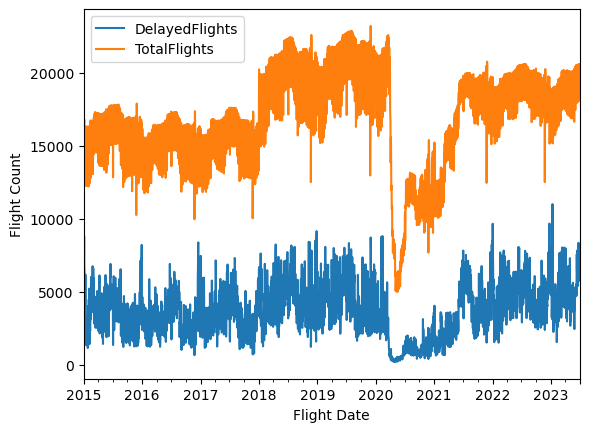

In [2]:
# Initial query to get flight counts aggregated by day across all airlines

qstr = '''
select FlightDate, count(*) as TotalFlights,
count(case when DepDel15==1 or ArrDel15==1 then Year end) as DelayedFlights,
count(case when Diverted==1 then Year end) as DivertedFlights,
count(case when Cancelled==1 then Year end) as CancelledFlights
from 'bts_faa_coords.parquet'
group by FlightDate
order by FlightDate
'''

df = duckdb.query(qstr).df()
df.FlightDate = pd.to_datetime(df.FlightDate)
df = df.set_index('FlightDate')

# First look at flight counts for the duration of the dataset

df.plot(y=['DelayedFlights', 'TotalFlights'],
        xlabel = "Flight Date", ylabel = "Flight Count")

It should be clear from the figure that there is some sort of seasonality to the data. There are also two very noteworthy characteristics which stand out:
* We can see a sharp decrease in total flights and delayed flights following the onset of the COVID-19 pandemic in 2020.
* We can also see a sharp increase in overall flight count in 2018. This may be due to inconsistent reporting by some of the airlines.

We decided it would be best to avoid the complications of the COVID-19 pandemic, so we will limit our analysis to data from January 2015 through December 2019.

<Axes: xlabel='Flight Date', ylabel='Flight Count'>

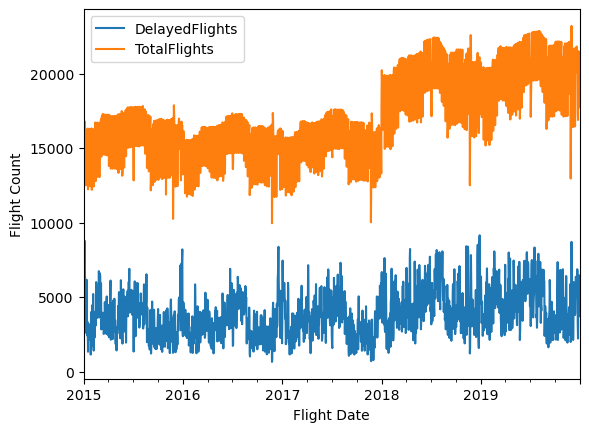

In [3]:
df = df[:'2019-12-31']
df.plot(y=['DelayedFlights', 'TotalFlights'],
        xlabel = "Flight Date", ylabel = "Flight Count")

Next, we'll examine what's behind the sharp increase in total flights starting at the beginning of 2018.

In [4]:
qstr = '''
select Year, Reporting_Airline, count(*) as TotalFlights
from 'bts_faa_coords.parquet'
group by Year, Reporting_Airline
order by Year asc, TotalFlights desc
'''

df_count = duckdb.query(qstr).df()
piv = df_count.pivot(columns='Reporting_Airline', index='Year', values='TotalFlights')
piv[:5]

Reporting_Airline,9E,AA,AS,B6,DL,EV,F9,G4,HA,MQ,NK,OH,OO,QX,UA,US,VX,WN,YV,YX
Year,,,,,,,,,,,,,,,,,,,,
2015,NaN,743739.0,173383.0,271843.0,883443.0,572642.0,93537.0,NaN,76272.0,294632.0,117379.0,NaN,594616.0,NaN,525289.0,199653.0,65057.0,1299774.0,NaN,NaN
2016,NaN,933141.0,178400.0,287017.0,931498.0,491267.0,97331.0,NaN,76789.0,NaN,138199.0,NaN,611612.0,NaN,554014.0,NaN,70485.0,1340436.0,NaN,NaN
2017,NaN,914954.0,186597.0,303282.0,936613.0,339700.0,106196.0,NaN,80172.0,NaN,156818.0,NaN,710582.0,NaN,598127.0,NaN,72333.0,1373493.0,NaN,NaN
2018,246611.0,938322.0,248852.0,309611.0,964461.0,202914.0,127910.0,98274.0,76483.0,296129.0,176178.0,278527.0,779735.0,NaN,635800.0,NaN,18006.0,1399105.0,217695.0,318105.0
2019,257727.0,969555.0,269181.0,301920.0,1008043.0,134743.0,141210.0,106627.0,83891.0,327011.0,210576.0,289304.0,840638.0,NaN,641723.0,NaN,NaN,1412672.0,230402.0,330444.0


We can see that there are several airlines that do not have data prior to 2018. We'll remove those airlines from our dataset. Note that we will keep the 2015 data from US (US Airways) as it folded into American Airlines (AA) the following year. So we will keep the following airlines:
* American (AA)
* Alaska (AS)
* JetBlue (B6)
* Delta (DL)
* ExpressJet (EV) - a regional carrier
* Frontier (F9)
* Hawaiian (HA)
* Spirit (NK)
* Skywest (OO) - a regional carrier
* Southwest (WN)
* United (UA)
* US Airways (US) - folded into American's statistics as of 2016
* Virgin America (VX) - folded into Alaska's statistics as of 2019

<Axes: xlabel='Flight Date', ylabel='Flight Count'>

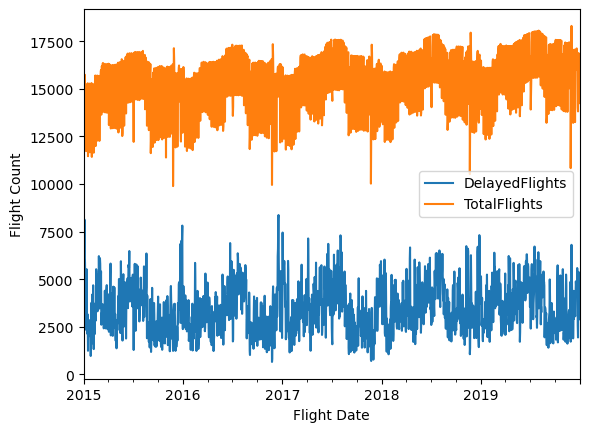

In [5]:
qstr = '''
select FlightDate, count(*) as TotalFlights,
count(case when DepDel15==1 or ArrDel15==1 then Year end) as DelayedFlights,
count(case when Diverted==1 then Year end) as DivertedFlights,
count(case when Cancelled==1 then Year end) as CancelledFlights
from 'bts_faa_coords.parquet'
where Reporting_Airline in ('AA','AS','B6','DL','EV','F9','HA','NK','OO','UA','US','VX','WN')
group by FlightDate
order by FlightDate
'''

df = duckdb.query(qstr).df()
df.FlightDate = pd.to_datetime(df.FlightDate)
# df = df.set_index(pd.PeriodIndex(df.FlightDate, freq='D'))
df = df.set_index('FlightDate')
# df = df.drop('FlightDate', axis=1)
df = df[:'2019-12-31']

df.plot(y=['DelayedFlights', 'TotalFlights'],
        xlabel = "Flight Date", ylabel = "Flight Count")

Again, we can see seasonal patterns in the data, and perhaps a trend as well. We need to understand whether the data is trend stationary - that is, does the mean change significantly over time. Let's take a look at a rolling average on a 180 day interval.

<Axes: xlabel='Flight Date', ylabel='Rolling Mean Flight Count'>

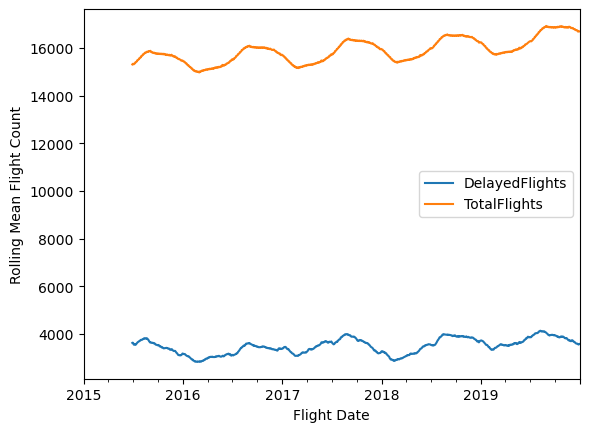

In [6]:
df.rolling(window=180).mean().plot(y=['DelayedFlights', 'TotalFlights'],
                                 xlabel = "Flight Date", ylabel = "Rolling Mean Flight Count")

An increasing trend in total flights is apparent, but it isn't clear whether there is a trend in delayed flights. We do have some utilities from the *pmdarima* library to give us more insight.

In [7]:
# Augmented Dickey Fuller Test (ADF)
d_adf = ndiffs(np.array(df.DelayedFlights), test='adf')

# Phillips-Perron Test (PP)
d_pp = ndiffs(np.array(df.DelayedFlights), test='pp')

# Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)
d_kpss = ndiffs(np.array(df.DelayedFlights), test='kpss')

print("Suggested d hyperparameter:")
print(f"ADF: {d_adf}; PP: {d_pp}; KPSS: {d_kpss}")

Suggested d hyperparameter:
ADF: 0; PP: 0; KPSS: 1


The KPSS test suggests that we should difference the data once in order to make it stationary. What about for the seasonal component? The *pmdarima* library can help us again.

In [8]:
# Canova-Hansen
D_ch_7 = nsdiffs(np.array(df.DelayedFlights), m=7, max_D=10, test='ch')
D_ch_30 = nsdiffs(np.array(df.DelayedFlights), m=30, max_D=10, test='ch')
D_ch_365 = nsdiffs(np.array(df.DelayedFlights), m=365, max_D=10, test='ch')

# Osborn, Chui, Smith, and Birchenhall Test (OCSB)
D_ocsb_7 = nsdiffs(np.array(df.DelayedFlights), m=7, max_D=10, test='ocsb')
D_ocsb_30 = nsdiffs(np.array(df.DelayedFlights), m=30, max_D=10, test='ocsb')
D_ocsb_365 = nsdiffs(np.array(df.DelayedFlights), m=365, max_D=10, test='ocsb')

print("Suggested D hyperparameter:")
print(f"Weekly seasonality - CH: {D_ch_7}; OCSB: {D_ocsb_7}")
print(f"Monthly seasonality - CH: {D_ch_30}; OCSB: {D_ocsb_30}")
print(f"Annual seasonality - CH: {D_ch_365}; OCSB: {D_ocsb_365}")

Suggested D hyperparameter:
Weekly seasonality - CH: 0; OCSB: 0
Monthly seasonality - CH: 0; OCSB: 0
Annual seasonality - CH: 3; OCSB: 0


The test tells us that if we are using annual seasonality, we should consider a seasonal differencing parameter of 3.

## Choosing Relevant Models

To consider seasonality (weekly, monthly, and/or annual) and trends, there are several models we can use that might be effective, including:
* Autoregressive Integrated Moving Average (ARIMA)
* Seasonal Autoregressive Integrated Moving Average (SARIMA)
* SARIMA with Exogenous Factors (SARIMAX)
* Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components (TBATS)
* XGBoost

ARIMA does not model seasonality but is useful for baseline comparison. SARIMA, as its name suggests, does model seasonality. SARIMAX adds the ability to consider additional influences on the time series we are trying to predict. TBATS allows for the possibility of multiple seasonal patterns. XGBoost is not normally used for time series, but can be useful when exogenous features are created from the date.

### ARIMA Model

The *pmdarima* Python library has the *auto_arima* method to do a grid search around the model's hyperparamters, which are:
* p: the lag order
* d: number of times the data is differenced (zero for this stationary data)
* q: the moving average window

We need to split our data into training and test sets. We'll use 2015-2018 for training and 2019 for testing. This procedure is derived from an example provided in the pmdarina documentation [here](https://alkaline-ml.com/pmdarima/auto_examples/arima/example_auto_arima.html).

We are using mean absolute error (MAE) and mean absolute percentage error (MAPE) as metrics. MAE allows us to see directly how far off the model is on average in flight count. Including MAPE allows us to understand the scale of the error. MAPE should be what we seek to minimize. (We're also including Root Mean Squared Error for reference.)

In [12]:
train = df.DelayedFlights[:'2018-12-31']
test = df.DelayedFlights['2019-01-01':]

best_arima = pm.auto_arima(train,
                           d=1, seasonal=False, stepwise=True, 
                           suppress_warnings=True, trace=True)

preds = best_arima.predict(n_periods=test.shape[0])

order = best_arima.get_params()['order']
print('Optimal order:', order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24324.703, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24752.647, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24690.394, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24504.201, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24750.647, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24323.220, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=24322.317, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=24326.936, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24375.235, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=24327.376, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=24320.317, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=24502.201, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=24321.152, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=24324.936, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0

Text(0.5, 1.0, 'Flight Delay Prediction with ARIMA(0, 1, 2)\nBlue - Training; Green - Test; Orange - Prediction')

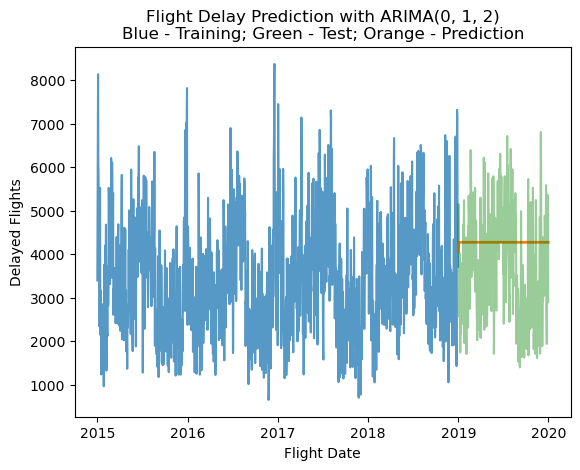

In [13]:
# Plot the results
x_axis = np.array(list(train.index) + list(preds.index))
plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=1, linewidth=2)
plt.plot(x_axis[train.shape[0]:], test, alpha=0.4, color='g')
plt.xlabel('Flight Date')
plt.ylabel('Delayed Flights')
order = best_arima.get_params()['order']
plt.title(f'Flight Delay Prediction with ARIMA{order}\nBlue - Training; Green - Test; Orange - Prediction')

In [14]:
mae = round(mean_absolute_error(test, preds),1)
mape = round(mean_absolute_percentage_error(test, preds)*100,1)
s_mape = round(smape(test, preds),1)
rmse = round(np.sqrt(mean_squared_error(test, preds)),1)

print(f"Mean Absolute Error (# flights): {mae}")
print(f"Mean Absolute Percentage Error: {mape}%")
print(f"Symmetric Mean Absolute Percentage Error: {s_mape}%")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error (# flights): 1116.7
Mean Absolute Percentage Error: 39.4%
Symmetric Mean Absolute Percentage Error: 30.3%
Root Mean Squared Error: 1325.7


This is not a good result. The MAE is 1116.7 flights, while the MAPE is 39.4%. (The Symmetric MAPE of 30.3% is included as it is something used for comparison by the *pmdarima* library. It is similar to the MAE, but is better in cases where zero values are part of the time series. This is not the case here, so SMAPE slightly underestimates the error. We'll continue using SMAPE going forward, as the *pmdarima* utilities for cross validation use that metric rather than MAPE.)

Clearly, the result does not capture any seasonal pattern (by definition), nor does it reflect the variance in the test data.

Let's also run a k-fold cross validation using a sliding window (as regular k-fold cannot be used with a time series). We'll choose k=8. Again, MAPE is not an available scoring method, so we'll use SMAPE.

In [26]:
def cv_metrics(model, data, h=91, step=182, window_size=365):
    
    # By default, sliding window with 365 days of training data and 91 days of test data, 
    # shifting by 181 days for each window
    cv = SlidingWindowForecastCV(h=h, step=step, window_size=window_size)

    cval_mse = cross_validate(model, y=data, scoring='mean_squared_error', cv=cv, verbose=0)
    cval_mae = cross_validate(model, y=data, scoring='mean_absolute_error', cv=cv, verbose=0)
    cval_smape = cross_validate(model, y=data, scoring='smape', cv=cv, verbose=0)

    folds = len(cval_mse['test_score'])
    cv_mse_list = []
    for item in cval_mse['test_score']:
        cv_mse_list.append(np.sqrt(item))

    cv_mse = (round(np.array(cv_mse_list).mean(), 1), round(np.array(cv_mse_list).std(), 1))
    cv_mae = (round(cval_mae['test_score'].mean(),1), round(cval_mae['test_score'].std(),1))
    cv_smape = (round(cval_smape['test_score'].mean(),1), round(cval_smape['test_score'].std(),1))
    
    return folds, cv_mae, cv_smape, cv_mse

folds, cv_mae, cv_smape, cv_mse = cv_metrics(best_arima, df.DelayedFlights[:'2019-12-31'])

print(f"With {folds}-fold sliding window cross validation:")
print(f"Mean Absolute Error: {cv_mae[0]} (SD: {cv_mae[1]})")
print(f"Symmetric Mean Absolute Percentage Error: {cv_smape[0]}% (SD: {cv_smape[1]}%))")
print(f"Root Mean Squared Error: {cv_mse[0]} (SD: {cv_mse[1]})")

With 8-fold sliding window cross validation:
Mean Absolute Error: 1358.6 (SD: 258.2)
Symmetric Mean Absolute Percentage Error: 36.7% (SD: 7.0%))
Root Mean Squared Error: 1592.2 (SD: 259.7)


The error increases with cross validation, with MAE at 1358.6 flights and SMAPE at 36.7%.

### ARIMA Sensitivity Analysis

What happens to the calculated metrics if we vary p and q (leaving d=1)? We'll use cross-validation to evaluate the differences.

In [38]:
import warnings
warnings.filterwarnings('ignore')

for p in (0,1,2,3):
    for q in (0,1,2,3):
        sens = arima.ARIMA(order=(p,1,q))
        folds, mae, mape, rmse = cv_metrics(sens, df.DelayedFlights[:'2019-12-31'])
        order = f'({p}, 1, {q})'
        print(f'ARIMA{order}\tSMAPE: {mape}\tMAE: {mae}\tRMSE: {rmse}')

ARIMA(0, 1, 0)	SMAPE: (41.3, 13.8)	MAE: (1714.0, 954.0)	RMSE: (1946.9, 948.3)
ARIMA(0, 1, 1)	SMAPE: (41.3, 10.2)	MAE: (1608.4, 444.9)	RMSE: (1861.2, 424.4)
ARIMA(0, 1, 2)	SMAPE: (38.3, 7.3)	MAE: (1443.3, 286.4)	RMSE: (1688.4, 293.8)
ARIMA(0, 1, 3)	SMAPE: (39.5, 8.9)	MAE: (1510.2, 374.4)	RMSE: (1758.2, 370.1)
ARIMA(1, 1, 0)	SMAPE: (40.3, 11.5)	MAE: (1626.5, 754.8)	RMSE: (1863.1, 750.0)
ARIMA(1, 1, 1)	SMAPE: (36.8, 6.4)	MAE: (1364.1, 252.3)	RMSE: (1603.7, 272.2)
ARIMA(1, 1, 2)	SMAPE: (38.6, 7.9)	MAE: (1457.8, 318.3)	RMSE: (1706.0, 321.8)
ARIMA(1, 1, 3)	SMAPE: (39.6, 8.5)	MAE: (1514.3, 347.5)	RMSE: (1766.2, 347.2)
ARIMA(2, 1, 0)	SMAPE: (41.9, 6.5)	MAE: (1641.6, 322.6)	RMSE: (1907.2, 321.7)
ARIMA(2, 1, 1)	SMAPE: (41.2, 9.6)	MAE: (1602.1, 408.3)	RMSE: (1851.3, 403.6)
ARIMA(2, 1, 2)	SMAPE: (38.4, 7.1)	MAE: (1450.9, 283.3)	RMSE: (1699.1, 294.6)
ARIMA(2, 1, 3)	SMAPE: (40.9, 9.4)	MAE: (1594.3, 419.6)	RMSE: (1853.3, 429.8)
ARIMA(3, 1, 0)	SMAPE: (40.7, 5.4)	MAE: (1575.8, 263.1)	RMSE: (1845.0, 271

Cross validated SMAPE ranges from 35.7% to 41.9% when varying the hyperparameters. Note that what *auto_arima* says is the optimal model appears not to be the model with the lowest MAE or SMAPE. This is because the *auto_arima* method seeks to minimize the Akaike Information Criterion (AIC). We could do a manual grid search (as we did above) to find the model with the lowest SMAPE, which appears to be of order (3,1,1). 

Text(0.5, 1.0, 'Blue - Training; Green - Test; Orange - Prediction')

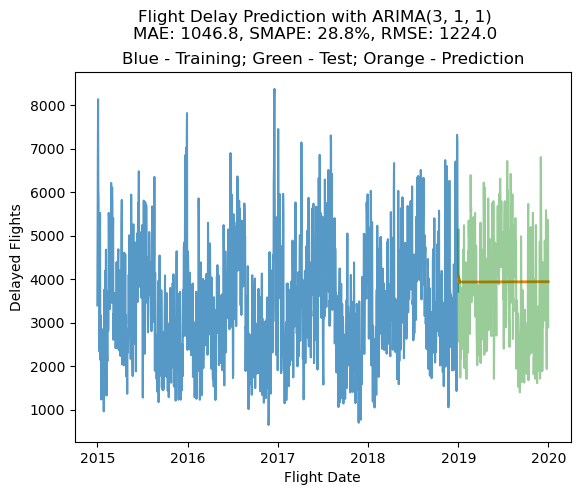

In [30]:
sens = arima.ARIMA(order=(3,1,1)).fit(train)
preds = sens.predict(n_periods=test.shape[0])

# Plot the results
x_axis = np.array(list(train.index) + list(preds.index))
plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=1, linewidth=2)
plt.plot(x_axis[train.shape[0]:], test, alpha=0.4, color='g')
plt.xlabel('Flight Date')
plt.ylabel('Delayed Flights')
mae = round(mean_absolute_error(test, preds),1)
mape = round(smape(test, preds),1)
rmse = round(np.sqrt(mean_squared_error(test, preds)),1)
order = sens.get_params()['order']
plt.suptitle(f'Flight Delay Prediction with ARIMA{order}\nMAE: {mae}, SMAPE: {mape}%, RMSE: {rmse}', y=1.01)
plt.title(f'Blue - Training; Green - Test; Orange - Prediction')

### SARIMA Model

The next step is to add the seasonality. It looks like there is annual seasonality, but there may be shorter seasonal cycles - perhaps weekly or monthly. In any event, using annual seasonality is too computationally intensive so we will stick to monthly, and set m=30 using the same *auto_arima* method. Based on our earlier calculations, we will assume d=1 and D=0.

In [39]:
best_sarima = pm.auto_arima(train, d=1, D=0,
                            seasonal=True, m=30, stepwise=True, 
                            suppress_warnings=True, trace=True)

preds = best_sarima.predict(n_periods=test.shape[0])

order = best_sarima.get_params()['order']
sorder = best_sarima.get_params()['seasonal_order']
print('Optimal order:', order, sorder)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=24313.935, Time=4.75 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=24752.647, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=24651.015, Time=0.73 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=24493.836, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=24750.647, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=24313.596, Time=3.38 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=24324.703, Time=0.17 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=24315.338, Time=13.99 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=24313.099, Time=3.50 sec
 ARIMA(2,1,2)(2,0,0)[30] intercept   : AIC=24314.567, Time=16.35 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=24315.928, Time=23.44 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=24311.024, Time=2.86 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=24323.220, Time=0.13 sec
 ARIMA(1,1,2)(2,0,0)[30] intercept   : AIC=24312.862, Time=9.10 sec
 A

Text(0.5, 1.0, 'Blue - Training; Green - Test; Orange - Prediction')

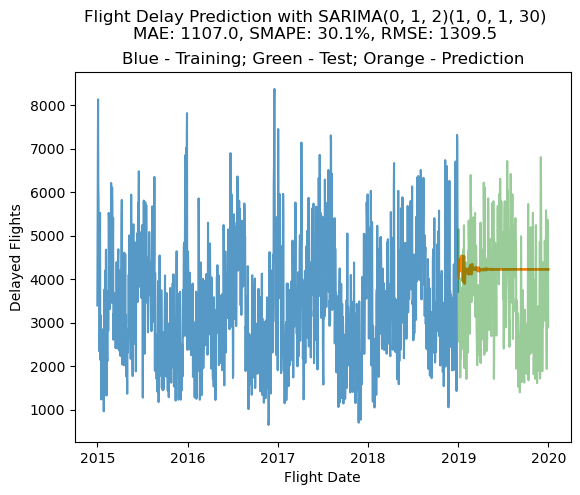

In [40]:
# Plot the results
x_axis = np.array(list(train.index) + list(preds.index))
plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=1, linewidth=2)
plt.plot(x_axis[train.shape[0]:], test, alpha=0.4, color='g')
plt.xlabel('Flight Date')
plt.ylabel('Delayed Flights')
mae = round(mean_absolute_error(test, preds),1)
mape = round(smape(test, preds),1)
rmse = round(np.sqrt(mean_squared_error(test, preds)),1)
order = best_sarima.get_params()['order']
sorder = best_sarima.get_params()['seasonal_order']
plt.suptitle(f'Flight Delay Prediction with SARIMA{order}{sorder}\nMAE: {mae}, SMAPE: {mape}%, RMSE: {rmse}', y=1.01)
plt.title(f'Blue - Training; Green - Test; Orange - Prediction')

For a single training run, this actually has higher SMAPE than without seasonality. However, it's clear from the result that the predictions are not really following the correct seasonal pattern. Let's verify with cross validation.

In [41]:
folds, cv_mae, cv_smape, cv_mse = cv_metrics(best_sarima, df.DelayedFlights[:'2019-12-31'])

print(f"With {folds}-fold sliding window cross validation:")
print(f"Mean Absolute Error: {cv_mae[0]} (SD: {cv_mae[1]})")
print(f"Symmetric Mean Absolute Percentage Error: {cv_smape[0]}% (SD: {cv_smape[1]}%))")
print(f"Root Mean Squared Error: {cv_mse[0]} (SD: {cv_mse[1]})")

With 8-fold sliding window cross validation:
Mean Absolute Error: 1279.6 (SD: 207.3)
Symmetric Mean Absolute Percentage Error: 35.1% (SD: 5.8%))
Root Mean Squared Error: 1503.5 (SD: 219.7)


Let's see if we get a reasonable result using m=7 (weekly seasonality). We'll also set D=0, as our earlier tests suggested seasonal differencing was not necessary for weekly seasonality.

In [42]:
best_sarima7 = pm.auto_arima(train, d=1, D=0,
                            seasonal=True, m=7, stepwise=True, 
                            suppress_warnings=True, trace=True)

preds = best_sarima7.predict(n_periods=test.shape[0])

order = best_sarima7.get_params()['order']
sorder = best_sarima7.get_params()['seasonal_order']
print('Optimal order:', order, sorder)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=24752.647, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=24527.264, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=24437.164, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=24750.647, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=24504.201, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=24406.264, Time=0.82 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=24579.105, Time=0.56 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=24228.093, Time=1.86 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=24266.160, Time=0.74 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=24532.3

Text(0.5, 1.0, 'Blue - Training; Green - Test; Orange - Prediction')

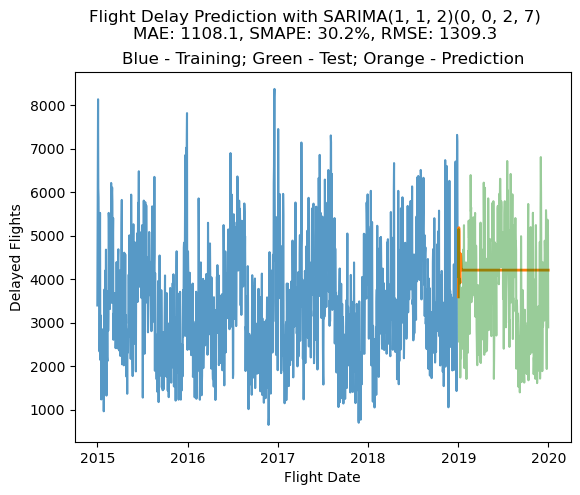

In [43]:
# Plot the results
x_axis = np.array(list(train.index) + list(preds.index))
plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=1, linewidth=2)
plt.plot(x_axis[train.shape[0]:], test, alpha=0.4, color='g')
plt.xlabel('Flight Date')
plt.ylabel('Delayed Flights')
mae = round(mean_absolute_error(test, preds),1)
mape = round(smape(test, preds),1)
rmse = round(np.sqrt(mean_squared_error(test, preds)),1)
order = best_sarima7.get_params()['order']
sorder = best_sarima7.get_params()['seasonal_order']
plt.suptitle(f'Flight Delay Prediction with SARIMA{order}{sorder}\nMAE: {mae}, SMAPE: {mape}%, RMSE: {rmse}', y=1.01)
plt.title(f'Blue - Training; Green - Test; Orange - Prediction')

This SARIMA model with m=7 is no better than with m=30. We are still not capturing seasonality correctly. For completeness, we can look at cross-validation scores.

In [50]:
folds, cv_mae, cv_smape, cv_mse = cv_metrics(best_sarima7, df.DelayedFlights[:'2019-12-31'])

print(f"With {folds}-fold sliding window cross validation:")
print(f"Mean Absolute Error: {cv_mae[0]} (SD: {cv_mae[1]})")
print(f"Symmetric Mean Absolute Percentage Error: {cv_smape[0]}% (SD: {cv_smape[1]}%))")
print(f"Root Mean Squared Error: {cv_mse[0]} (SD: {cv_mse[1]})")

With 8-fold sliding window cross validation:
Mean Absolute Error: 1307.0 (SD: 328.0)
Symmetric Mean Absolute Percentage Error: 35.5% (SD: 8.0%))
Root Mean Squared Error: 1533.8 (SD: 335.5)


### SARIMA Sensitivity Analysis

Holding the non-seasonal parameters constant at (0,1,2), leaving D=0 and m=30, we can vary P and Q to see what happens to our error terms.

In [45]:
for P in (0,1,2):
    for Q in (0,1,2):
        sens = arima.ARIMA(order=(0,1,2), seasonal_order=(P,0,Q,30))
        folds, mae, mape, rmse = cv_metrics(sens, df.DelayedFlights[:'2019-12-31'])
        order = f'(0, 1, 2)({P}, 0, {Q}, 30)'
        print(f'SARIMA{order}\tSMAPE: {mape}\tMAE: {mae}\tRMSE: {rmse}')

SARIMA(2, 1, 2)(0, 0, 0, 7)	SMAPE: (38.3, 7.3)	MAE: (1443.3, 286.4)%	RMSE: (1688.4, 293.8)
SARIMA(2, 1, 2)(0, 0, 1, 7)	SMAPE: (36.6, 6.5)	MAE: (1351.4, 247.4)%	RMSE: (1582.7, 256.6)
SARIMA(2, 1, 2)(0, 0, 2, 7)	SMAPE: (36.7, 6.0)	MAE: (1358.5, 226.1)%	RMSE: (1592.0, 243.2)
SARIMA(2, 1, 2)(1, 0, 0, 7)	SMAPE: (36.5, 6.8)	MAE: (1348.4, 263.5)%	RMSE: (1579.1, 273.5)
SARIMA(2, 1, 2)(1, 0, 1, 7)	SMAPE: (36.4, 6.3)	MAE: (1343.6, 245.9)%	RMSE: (1577.1, 263.0)
SARIMA(2, 1, 2)(1, 0, 2, 7)	SMAPE: (36.5, 6.1)	MAE: (1347.8, 229.8)%	RMSE: (1581.9, 247.2)
SARIMA(2, 1, 2)(2, 0, 0, 7)	SMAPE: (36.6, 6.2)	MAE: (1354.8, 236.7)%	RMSE: (1588.3, 251.1)
SARIMA(2, 1, 2)(2, 0, 1, 7)	SMAPE: (36.5, 6.7)	MAE: (1348.5, 257.3)%	RMSE: (1580.1, 268.0)
SARIMA(2, 1, 2)(2, 0, 2, 7)	SMAPE: (37.4, 6.3)	MAE: (1411.1, 286.4)%	RMSE: (1656.6, 325.4)


SMAPE varies from 36.4% to 38.3% as we vary P and Q. None of these results improves upon 35.1% cross validated SMAPE from the original model.

### Seasonality via Exogenous Variables

Clearly, training models for long seasonality periods is quite computationally expensive. However, we can potentially get the same results by using Fourier terms as exogenous variables.

In [46]:
# Create terms to support annual seasonality
ff = FourierFeaturizer(365, 4)
y = df.DelayedFlights[:'2019-12-31']
y, exog = ff.fit_transform(y)
exog.index = y.index

train = y[:'2018-12-31']
exog_train = exog[:'2018-12-31']
test = y['2019-01-01':]
exog_test = exog['2019-01-01':]

best_arimax = pm.auto_arima(train, X=exog_train, d=1, D=3,
                            stepwise=True, suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24768.189, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24705.573, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24513.661, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24766.191, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=24319.459, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24321.366, Time=0.90 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=24317.417, Time=1.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=24317.954, Time=1.66 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=24315.551, Time=0.83 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=24317.460, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2

Text(0.5, 1.0, 'Blue - Training; Green - Test; Orange - Prediction')

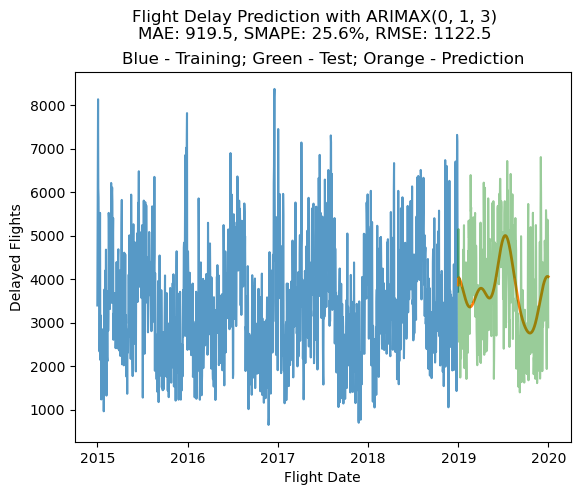

In [47]:
preds = best_arimax.predict(n_periods=test.shape[0], X=exog_test)

# Plot the results
x_axis = np.array(list(train.index) + list(preds.index))
plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=1, linewidth=2)
plt.plot(x_axis[train.shape[0]:], test, alpha=0.4, color='g')
plt.xlabel('Flight Date')
plt.ylabel('Delayed Flights')
mae = round(mean_absolute_error(test, preds),1)
mape = round(smape(test, preds),1)
rmse = round(np.sqrt(mean_squared_error(test, preds)),1)
order = best_arimax.get_params()['order']
plt.suptitle(f'Flight Delay Prediction with ARIMAX{order}\nMAE: {mae}, SMAPE: {mape}%, RMSE: {rmse}', y=1.01)
plt.title(f'Blue - Training; Green - Test; Orange - Prediction')

This is promising! SMAPE is down to 25.6%, MAE is 919.5, and the predictions clearly follow the pattern of the test data, although perhaps not the range of the variance. Furthermore, it took just 17 seconds to train this model. Let's look at the cross validation.

In [54]:
folds, cv_mae, cv_smape, cv_mse = cv_metrics(best_arimax, df.DelayedFlights[:'2019-12-31'])

print(f"With {folds}-fold sliding window cross validation:")
print(f"Mean Absolute Error: {cv_mae[0]} (SD: {cv_mae[1]})")
print(f"Symmetric Mean Absolute Percentage Error: {cv_smape[0]}% (SD: {cv_smape[1]}%))")
print(f"Root Mean Squared Error: {cv_mse[0]} (SD: {cv_mse[1]})")

With 8-fold sliding window cross validation:
Mean Absolute Error: 1391.8 (SD: 291.5)
Symmetric Mean Absolute Percentage Error: 37.4% (SD: 7.6%))
Root Mean Squared Error: 1629.7 (SD: 288.7)


### "Mini" Exogenous Sensitivity Analysis 

Interestingly, even though this model "looks better," the MAE, SMAPE, and RMSE are all higher than for the SARIMA model with m=7 or m=30. We can add additional terms to the exogenous variables for weekly seasonality and see if that improves things.

In [51]:
# Create terms to support annual seasonality
ff365 = FourierFeaturizer(365, 4)
y = df.DelayedFlights[:'2019-12-31']
y, exog = ff365.fit_transform(y)
exog.index = y.index

# Create terms for weekly seasonality
ff7 = FourierFeaturizer(7, 3)
y, exog2 = ff7.fit_transform(y)
exog2.index = y.index

exog = pd.concat([exog,exog2], axis=1)

train = y[:'2018-12-31']
exog_train = exog[:'2018-12-31']
test = y['2019-01-01':]
exog_test = exog['2019-01-01':]

best_arimax2 = pm.auto_arima(train, X=exog_train, d=1, D=3,
                             stepwise=True, suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24253.811, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24215.233, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24153.596, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24251.834, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23962.609, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=23947.219, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=23945.219, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=23960.519, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=1.8

Text(0.5, 1.0, 'Blue - Training; Green - Test; Orange - Prediction')

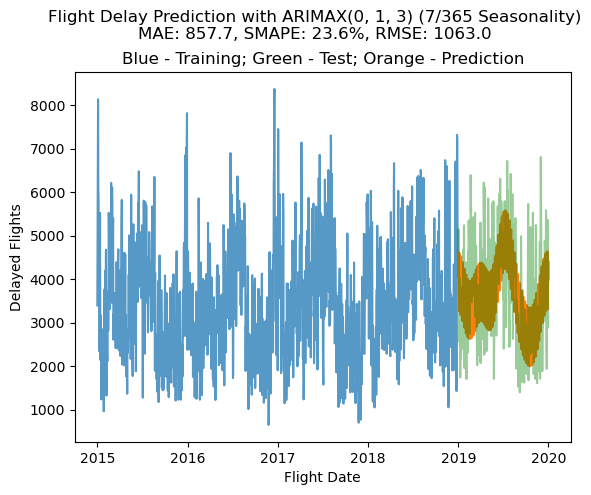

In [55]:
preds = best_arimax2.predict(n_periods=test.shape[0], X=exog_test)

# Plot the results
x_axis = np.array(list(train.index) + list(preds.index))
plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=1, linewidth=2)
plt.plot(x_axis[train.shape[0]:], test, alpha=0.4, color='g')
plt.xlabel('Flight Date')
plt.ylabel('Delayed Flights')
mae = round(mean_absolute_error(test, preds),1)
mape = round(smape(test, preds),1)
rmse = round(np.sqrt(mean_squared_error(test, preds)),1)
order = best_arimax2.get_params()['order']
plt.suptitle(f'Flight Delay Prediction with ARIMAX{order} (7/365 Seasonality)\nMAE: {mae}, SMAPE: {mape}%, RMSE: {rmse}', y=1.01)
plt.title(f'Blue - Training; Green - Test; Orange - Prediction')

Adding weekly seasonality to the annual seasonality has a notable improvement on the result and it looks like it fits the variance of the data better. Let's see if that holds with cross validation.

In [58]:
folds, cv_mae, cv_smape, cv_mse = cv_metrics(best_arimax2, df.DelayedFlights[:'2019-12-31'])

print(f"With {folds}-fold sliding window cross validation:")
print(f"Mean Absolute Error: {cv_mae[0]} (SD: {cv_mae[1]})")
print(f"Symmetric Mean Absolute Percentage Error: {cv_smape[0]}% (SD: {cv_smape[1]}%))")
print(f"Root Mean Squared Error: {cv_mse[0]} (SD: {cv_mse[1]})")

With 8-fold sliding window cross validation:
Mean Absolute Error: 1391.8 (SD: 291.5)
Symmetric Mean Absolute Percentage Error: 37.4% (SD: 7.6%))
Root Mean Squared Error: 1629.7 (SD: 288.7)


While the model "looks" better with both weekly and annual seasonality, it is no better from the standpoint of cross validated metrics. It's also still not as "good" as the straight SARIMA model even though it doesn't track seasonality properly. There may be more of a tendency to overfit with this strategy. Let's do a little more sensitivity analysis by varying p and q to see if we find a better fit.

In [57]:
for p in (0,1,2,3):
    for q in (0,1,2,3):
        sens = arima.ARIMA(order=(p,1,q), X=exog_train)
        folds, mae, mape, rmse = cv_metrics(sens, df.DelayedFlights[:'2019-12-31'])
        order = f'({p}, 1, {q})'
        print(f'ARIMAX{order}\tSMAPE: {mape}\tMAE: {mae}\tRMSE: {rmse}')

ARIMAX(0, 1, 0)	SMAPE: (41.3, 13.8)	MAE: (1714.0, 954.0)	RMSE: (1946.9, 948.3)
ARIMAX(0, 1, 1)	SMAPE: (41.3, 10.2)	MAE: (1608.4, 444.9)	RMSE: (1861.2, 424.4)
ARIMAX(0, 1, 2)	SMAPE: (38.3, 7.3)	MAE: (1443.3, 286.4)	RMSE: (1688.4, 293.8)
ARIMAX(0, 1, 3)	SMAPE: (39.5, 8.9)	MAE: (1510.2, 374.4)	RMSE: (1758.2, 370.1)
ARIMAX(1, 1, 0)	SMAPE: (40.3, 11.5)	MAE: (1626.5, 754.8)	RMSE: (1863.1, 750.0)
ARIMAX(1, 1, 1)	SMAPE: (36.8, 6.4)	MAE: (1364.1, 252.3)	RMSE: (1603.7, 272.2)
ARIMAX(1, 1, 2)	SMAPE: (38.6, 7.9)	MAE: (1457.8, 318.3)	RMSE: (1706.0, 321.8)
ARIMAX(1, 1, 3)	SMAPE: (39.6, 8.5)	MAE: (1514.3, 347.5)	RMSE: (1766.2, 347.2)
ARIMAX(2, 1, 0)	SMAPE: (41.9, 6.5)	MAE: (1641.6, 322.6)	RMSE: (1907.2, 321.7)
ARIMAX(2, 1, 1)	SMAPE: (41.2, 9.6)	MAE: (1602.1, 408.3)	RMSE: (1851.3, 403.6)
ARIMAX(2, 1, 2)	SMAPE: (38.4, 7.1)	MAE: (1450.9, 283.3)	RMSE: (1699.1, 294.6)
ARIMAX(2, 1, 3)	SMAPE: (40.9, 9.4)	MAE: (1594.3, 419.6)	RMSE: (1853.3, 429.8)
ARIMAX(3, 1, 0)	SMAPE: (40.7, 5.4)	MAE: (1575.8, 263.1)	RMSE:

There is a wide variation of SMAPE here, ranging from 35.7% to 41.9%.

### SARIMAX Model

For SARIMAX, we have the opportunity to introduce some exogenous data into the model. That is, to identify other items in our dataset that might influence the count of flight delays. Here, we might be able to use some information about the specific aircraft from the FAA registration data. However, it is critical to note that we can only use what we can aggregate to the daily level.

In [62]:
qstr = '''
select FlightDate, count(*) as TotalFlights, count(distinct Tail_Number) as Aircraft,
mean(Distance) as Distance, 
mean(case when "YEAR MFR"!='    ' then cast("YEAR MFR" as Integer) end) as YearMfr,
count(case when DepDel15==1 or ArrDel15==1 then Year end) as DelayedFlights,
count(case when Diverted==1 then Year end) as DivertedFlights,
count(case when Cancelled==1 then Year end) as CancelledFlights,
count(case when MFR_aircraft like '%AIRBUS%' then MFR_aircraft end) as AirbusFlights,
count(case when MFR_aircraft like '%BOEING%' then MFR_aircraft end) as BoeingFlights,
count(case when MFR_aircraft like '%EMBRAER%' then MFR_aircraft end) as EmbraerFlights,
count(case when MFR like 'CFM%' then MFR end) as CFMFlights,
count(case when MFR like 'GE%' then MFR end) as GEFlights,
count(case when MFR like 'P%' then MFR end) as PWFlights,
count(case when MFR like 'ROLL%' then MFR end) as RRFlights,
from 'bts_faa_coords.parquet'
where Reporting_Airline in ('AA','AS','B6','DL','EV','F9','HA','NK','OO','UA','US','VX')
group by FlightDate
order by FlightDate
'''

df = duckdb.query(qstr).df()
df.FlightDate = pd.to_datetime(df.FlightDate)
df = df.set_index('FlightDate')

So our exogenous variables could include:
* The total number of flights in a day
* The total number of aircraft flown in a day
* The average flight distance in a day
* The average year of manufacture of the aircraft flown in a day
* The number of flights on Airbus aircraft in a day
* The number of flights on Boeing aircraft in a day
* The number of flights on Embraer aircraft in a day
* The number of flights with CFM engines in a day
* The number of flights with GE engines in a day
* The number of flights with Pratt & Whitney engines in a day
* The number of flights with Rolls-Royce engines in a day

We'll try them all first. Rather than model the seasonality directly, we'll use our Fourier features and combine them with the exogenous variables we're reading directly from the data.

In [63]:
df_train = df[:'2018-12-31']
df_test = df['2019-01-01':'2019-12-31']

exog_cols = ['TotalFlights', 'Aircraft','Distance','YearMfr','AirbusFlights','BoeingFlights','EmbraerFlights',
                'CFMFlights','GEFlights','PWFlights','RRFlights']

train = df_train.DelayedFlights
test = df_test.DelayedFlights

exog_train_new = pd.concat([df_train[exog_cols], exog_train], axis=1)
exog_test_new = pd.concat([df_test[exog_cols], exog_test], axis=1)

best_sarimax = pm.auto_arima(train, X=exog_train_new, d=1, D=3,
                             stepwise=True, suppress_warnings=True, trace=True)

preds = best_sarimax.predict(n_periods=test.shape[0], X=exog_test_new)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23107.911, Time=2.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23160.691, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23143.127, Time=2.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23141.886, Time=2.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23158.699, Time=3.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23107.229, Time=2.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23107.258, Time=2.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23072.351, Time=2.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23100.061, Time=2.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23105.181, Time=2.74 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23108.172, Time=2.68 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 27.614 seconds


Text(0.5, 1.0, 'Blue - Training; Green - Test; Orange - Prediction')

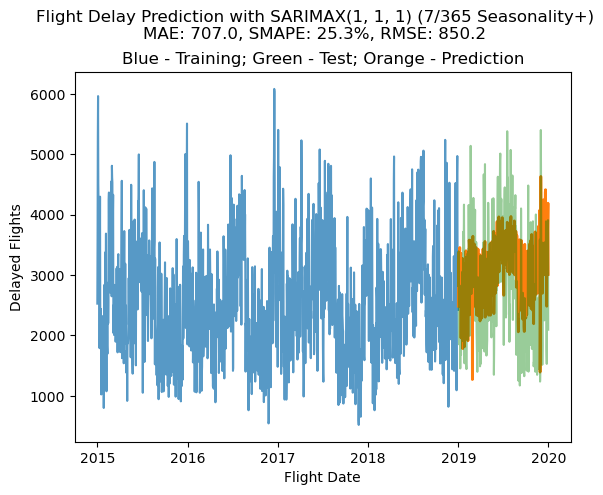

In [64]:
# Plot the results
x_axis = np.array(list(train.index) + list(preds.index))
plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=1, linewidth=2)
plt.plot(x_axis[train.shape[0]:], test, alpha=0.4, color='g')
plt.xlabel('Flight Date')
plt.ylabel('Delayed Flights')
mae = round(mean_absolute_error(test, preds),1)
mape = round(smape(test, preds),1)
rmse = round(np.sqrt(mean_squared_error(test, preds)),1)
order = best_sarimax.get_params()['order']
plt.suptitle(f'Flight Delay Prediction with SARIMAX{order} (7/365 Seasonality+)\nMAE: {mae}, SMAPE: {mape}%, RMSE: {rmse}', y=1.01)
plt.title(f'Blue - Training; Green - Test; Orange - Prediction')

Adding these variables actually increases the error. Let's verify that with cross validation.

In [65]:
folds, cv_mae, cv_smape, cv_mse = cv_metrics(best_sarimax, df.DelayedFlights[:'2019-12-31'])

print(f"With {folds}-fold sliding window cross validation:")
print(f"Mean Absolute Error: {cv_mae[0]} (SD: {cv_mae[1]})")
print(f"Symmetric Mean Absolute Percentage Error: {cv_smape[0]}% (SD: {cv_smape[1]}%))")
print(f"Root Mean Squared Error: {cv_mse[0]} (SD: {cv_mse[1]})")

With 8-fold sliding window cross validation:
Mean Absolute Error: 962.8 (SD: 170.8)
Symmetric Mean Absolute Percentage Error: 34.7% (SD: 5.1%))
Root Mean Squared Error: 1129.5 (SD: 192.3)


So as it turns out, adding exogenous information about the flights does improve our error. We could experiment with different combinations of the exogenous variables to see if we can get a better result, but it's not clear that it would help.

### TBATS Model

So far, we have had limited success in capturing the seasonality of the training data in the models we have chosen. The TBATS model allows direct application of multiple seasonal patterns in a dataset (without Fourier tricks), and that may be helpful.

Let's assume there are weekly (7) and annual (365.25) patterns in the data. Note that we can use fractional numbers to be able to capture the leap year.

In [66]:
estimator = TBATS(seasonal_periods=(7, 365.25))
model = estimator.fit(train)
preds = model.forecast(steps=test.shape[0])

Text(0.5, 1.0, 'Flight Delay Prediction with TBATS (2 Seasonalities)\nMAE: 663.3; SMAPE: 23.9%; RMSE: 860.1')

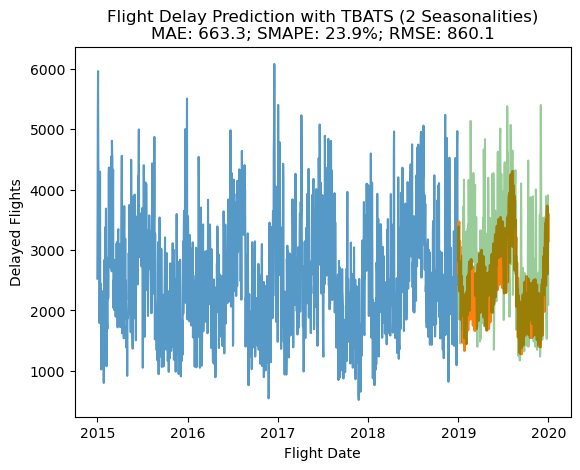

In [67]:
# Plot the results
preds = pd.Series(preds, index=test.index)
x_axis = np.array(list(train.index) + list(test.index))
plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=1, linewidth=2)
plt.plot(x_axis[train.shape[0]:], test, alpha=0.4, color='g')
plt.xlabel('Flight Date')
plt.ylabel('Delayed Flights')
mae = round(mean_absolute_error(test, preds),1)
mape = round(smape(test, preds),1)
rmse = round(np.sqrt(mean_squared_error(test, preds)),1)
plt.title(f'Flight Delay Prediction with TBATS (2 Seasonalities)\nMAE: {mae}; SMAPE: {mape}%; RMSE: {rmse}')

Surprisingly, this offers us a very good result with no need to adjust hyperparameters. Let's check the cross validation results.

In [69]:
# The function we wrote earlier will only work with pmdarima estimators, so we'll write a custom function.
cv_mae_list = []
cv_smape_list = []
cv_rmse_list = []
folds = 0

cv = SlidingWindowForecastCV(h=91, step=182, window_size=365)
y = df.DelayedFlights[:'2019-12-31']
for item in cv.split(y):
    train = y[item[0]]
    test = y[item[1]]
    model = estimator.fit(train)
    preds = pd.Series(model.forecast(steps=test.shape[0]), index=test.index)    
    item_mae = mean_absolute_error(test, preds)
    cv_mae_list.append(item_mae)
    item_smape = smape(test, preds)
    cv_smape_list.append(item_smape)
    item_rmse = np.sqrt(mean_squared_error(test, preds))
    cv_rmse_list.append(item_rmse)
    folds +=1

cv_mae = round(np.array(cv_mae_list).mean(),1), round(np.array(cv_mae_list).std(),1)
cv_smape = round(np.array(cv_smape_list).mean(),1), round(np.array(cv_smape_list).std(),1)
cv_rmse = round(np.array(cv_rmse_list).mean(),1), round(np.array(cv_rmse_list).std(),1)

print(f"With {folds}-fold sliding window cross validation:")
print(f"Mean Absolute Error: {cv_mae[0]} (SD: {cv_mae[1]})")
print(f"Symmetric Mean Absolute Percentage Error: {cv_smape[0]}% (SD: {cv_smape[1]}%))")
print(f"Root Mean Squared Error: {cv_rmse[0]} (SD: {cv_rmse[1]})")

With 8-fold sliding window cross validation:
Mean Absolute Error: 945.0 (SD: 237.3)
Symmetric Mean Absolute Percentage Error: 34.2% (SD: 7.1%))
Root Mean Squared Error: 1111.4 (SD: 233.3)


This is a good result, and an improvement over everything we've tried in the ARIMA family. This also seems to more correctly account for the seasonality patterns in the data. We have one more model to try.

### XGBoost

Although we usually don't think of using XGBoost for a time series, it can be effective in this role. We need to create exogenous features for different aspects of the date. This is similar to what we did to emulate SARIMA without the computational overhead, but does not rely on Fourier terms. This technique is adapted from a Kaggle tutorial [here](https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost).

In [70]:
# Create date features
dfx = df[['DelayedFlights']][:'2019-12-31'].copy()
dfx['date'] = dfx.index
dfx['dayofweek'] = dfx['date'].dt.dayofweek
dfx['quarter'] = dfx['date'].dt.quarter
dfx['month'] = dfx['date'].dt.month
dfx['year'] = dfx['date'].dt.year
dfx['dayofyear'] = dfx['date'].dt.dayofyear
dfx['dayofmonth'] = dfx['date'].dt.day

# Set up test and training data
exog_cols = ['dayofweek','quarter','month','year','dayofyear','dayofmonth']
X = dfx[exog_cols]
y = dfx.DelayedFlights

X_train = X[:'2018-12-31']
X_test = X['2019-01-01':]
y_train = y[:'2018-12-31']
y_test = y['2019-01-01':]


In [71]:
# Train the model
model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

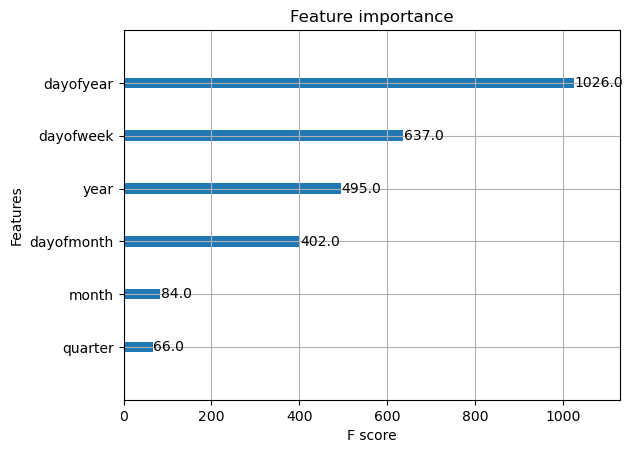

In [72]:
plot_importance(model)

The feature importance from the XGBoost model makes the day of year most important followed by day of week. It supports our intuition that there is both a weekly and annual seasonality to our data. Now let's see the model results.

Text(0.5, 1.0, 'Flight Delay Prediction with XGBoost\nMAE: 658.8; SMAPE: 24.1%; RMSE: 840.3')

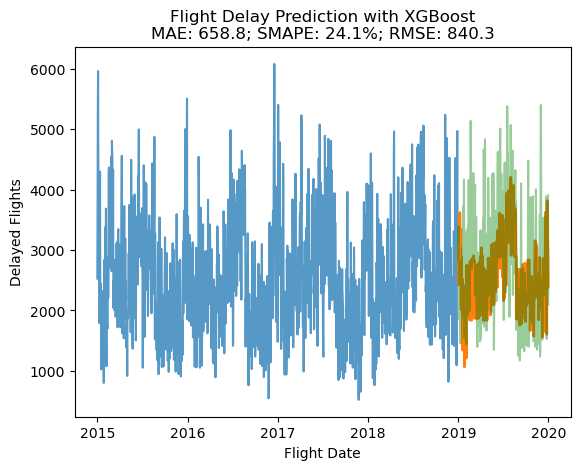

In [73]:
preds = model.predict(X_test)
preds = pd.Series(preds, index = X_test.index)

# Plot the results
x_axis = np.array(list(X_train.index) + list(X_test.index))
plt.plot(x_axis[:X_train.shape[0]], y_train, alpha=0.75)
plt.plot(x_axis[X_train.shape[0]:], preds, alpha=1, linewidth=2)
plt.plot(x_axis[X_train.shape[0]:], y_test, alpha=0.4, color='g')
plt.xlabel('Flight Date')
plt.ylabel('Delayed Flights')
mae = round(mean_absolute_error(y_test, preds),1)
mape = round(smape(y_test, preds),1)
rmse = round(np.sqrt(mean_squared_error(y_test, preds)),1)
plt.title(f'Flight Delay Prediction with XGBoost\nMAE: {mae}; SMAPE: {mape}%; RMSE: {rmse}')

Also very promising. Let's look at cross validation.

In [74]:
# The function we wrote earlier will only work with pmdarima estimators, so we'll write a custom function.
cv_mae_list = []
cv_smape_list = []
cv_rmse_list = []
folds = 0

cv = SlidingWindowForecastCV(h=91, step=182, window_size=365)
X = dfx[exog_cols]
y = dfx.DelayedFlights
for item in cv.split(y):
    y_train = y[item[0]]
    y_test = y[item[1]]
    X_train = X.iloc[item[0],:]
    X_test = X.iloc[item[1],:]
    model = xgb.XGBRegressor(n_estimators=1000,
                             early_stopping_rounds=50).fit(X_train, y_train,
                                                           eval_set=[(X_train, y_train), (X_test, y_test)],
                                                           verbose=False)
    preds = pd.Series(model.predict(X_test), index=X_test.index)    
    item_mae = mean_absolute_error(y_test, preds)
    cv_mae_list.append(item_mae)
    item_smape = smape(y_test, preds)
    cv_smape_list.append(item_smape)
    item_rmse = np.sqrt(mean_squared_error(y_test, preds))
    cv_rmse_list.append(item_rmse)
    folds +=1

cv_mae = round(np.array(cv_mae_list).mean(),1), round(np.array(cv_mae_list).std(),1)
cv_smape = round(np.array(cv_smape_list).mean(),1), round(np.array(cv_smape_list).std(),1)
cv_rmse = round(np.array(cv_rmse_list).mean(),1), round(np.array(cv_rmse_list).std(),1)

print(f"With {folds}-fold sliding window cross validation:")
print(f"Mean Absolute Error: {cv_mae[0]} (SD: {cv_mae[1]})")
print(f"Symmetric Mean Absolute Percentage Error: {cv_smape[0]}% (SD: {cv_smape[1]}%))")
print(f"Root Mean Squared Error: {cv_rmse[0]} (SD: {cv_rmse[1]})")

With 8-fold sliding window cross validation:
Mean Absolute Error: 609.8 (SD: 76.7)
Symmetric Mean Absolute Percentage Error: 23.8% (SD: 3.0%))
Root Mean Squared Error: 784.9 (SD: 100.6)


We have a winner! XGBoost has the lowest error in cross validation of any of the variations we have tried in this notebook.

### XGBoost Hyperparameter Tuning

With a grid search, we can attempt to improve the performance of the XGBoost model.

In [144]:
params = {
    'learning_rate':[0.1, 0.3, 0.5, 0.7],
    'gamma':[0, 0.5, 1.0, 1.5, 2.0],
    'max_depth':[2, 4, 6, 8],
    'min_child_weight':[1, 3, 5],
    'subsample':[0.25, 0.5, 0.75, 1.0],
    'colsample_bytree':[0.25, 0.5, 0.75, 1.0], 
    'colsample_bylevel':[0.25, 0.5, 0.75, 1.0], 
    'colsample_bynode':[0.25, 0.5, 0.75, 1.0],   
}

# Set up test and training data
exog_cols = ['dayofweek','quarter','month','year','dayofyear','dayofmonth']
X = dfx[exog_cols]
y = dfx.DelayedFlights

X_train = X[:'2018-12-31']
X_test = X['2019-01-01':]
y_train = y[:'2018-12-31']
y_test = y['2019-01-01':]

gsc = GridSearchCV(
            estimator=xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50),
            param_grid=params,
            cv=None, scoring='neg_mean_absolute_percentage_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      verbose=False)

grid_result.best_params_


{'colsample_bylevel': 0.75,
 'colsample_bynode': 0.75,
 'colsample_bytree': 0.75,
 'gamma': 0,
 'learning_rate': 0.3,
 'max_depth': 8,
 'min_child_weight': 1,
 'subsample': 0.75}

In [148]:
grid_result.best_score_

-0.26627273885945413

Text(0.5, 1.0, 'Flight Delay Prediction with XGBoost (Tuned)\nMAE: 671.4; SMAPE: 24.6%; RMSE: 845.8')

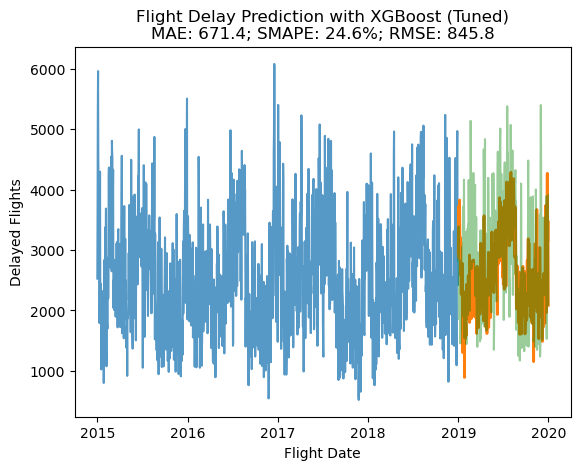

In [145]:
preds = grid_result.predict(X_test)
preds = pd.Series(preds, index = X_test.index)

# Plot the results
x_axis = np.array(list(X_train.index) + list(X_test.index))
plt.plot(x_axis[:X_train.shape[0]], y_train, alpha=0.75)
plt.plot(x_axis[X_train.shape[0]:], preds, alpha=1, linewidth=2)
plt.plot(x_axis[X_train.shape[0]:], y_test, alpha=0.4, color='g')
plt.xlabel('Flight Date')
plt.ylabel('Delayed Flights')
mae = round(mean_absolute_error(y_test, preds),1)
mape = round(smape(y_test, preds),1)
rmse = round(np.sqrt(mean_squared_error(y_test, preds)),1)
plt.title(f'Flight Delay Prediction with XGBoost (Tuned)\nMAE: {mae}; SMAPE: {mape}%; RMSE: {rmse}')

Despite a very long grid search cycle, overall performance did not improve. We'll check cross validation just to make sure.

In [75]:
# The function we wrote earlier will only work with pmdarima estimators, so we'll write a custom function.
cv_mae_list = []
cv_smape_list = []
cv_rmse_list = []
folds = 0

cv = SlidingWindowForecastCV(h=91, step=182, window_size=365)
X = dfx[exog_cols]
y = dfx.DelayedFlights
for item in cv.split(y):
    y_train = y[item[0]]
    y_test = y[item[1]]
    X_train = X.iloc[item[0],:]
    X_test = X.iloc[item[1],:]
    model = xgb.XGBRegressor(n_estimators=1000,
                             early_stopping_rounds=50,
                            gamma=0, learning_rate=0.3,
                            max_depth=8, min_child_weight=1,
                            subsample=0.75, colsample_bylevel=0.75,
                            colsample_bynode=0.75, 
                             colsample_bytree=0.75).fit(X_train, y_train,
                                                           eval_set=[(X_train, y_train), (X_test, y_test)],
                                                           verbose=False)
    preds = pd.Series(model.predict(X_test), index=X_test.index)    
    item_mae = mean_absolute_error(y_test, preds)
    cv_mae_list.append(item_mae)
    item_smape = smape(y_test, preds)
    cv_smape_list.append(item_smape)
    item_rmse = np.sqrt(mean_squared_error(y_test, preds))
    cv_rmse_list.append(item_rmse)
    folds +=1

cv_mae = round(np.array(cv_mae_list).mean(),1), round(np.array(cv_mae_list).std(),1)
cv_smape = round(np.array(cv_smape_list).mean(),1), round(np.array(cv_smape_list).std(),1)
cv_rmse = round(np.array(cv_rmse_list).mean(),1), round(np.array(cv_rmse_list).std(),1)

print(f"With {folds}-fold sliding window cross validation:")
print(f"Mean Absolute Error: {cv_mae[0]} (SD: {cv_mae[1]})")
print(f"Symmetric Mean Absolute Percentage Error: {cv_smape[0]}% (SD: {cv_smape[1]}%))")
print(f"Root Mean Squared Error: {cv_rmse[0]} (SD: {cv_rmse[1]})")

With 8-fold sliding window cross validation:
Mean Absolute Error: 610.8 (SD: 79.8)
Symmetric Mean Absolute Percentage Error: 23.7% (SD: 3.1%))
Root Mean Squared Error: 784.8 (SD: 98.4)


So with cross validation, this actually gave us a slight improvement in SMAPE and RMSE, but an increase in MAE. Here's the updated result:

| Model | MAE | SMAPE | RMSE |
| --- | --- | --- | --- |
| ARIMA(3,1,1) | 1319.4 (259.8) | 35.7% (5.8%) | 1565.1 (293.2) |
| SARIMA(0,1,2)(1,0,1,30) | 1279.6 | 35.1% (5.8%) | 1503.5 (219.7) |
| "SARIMAX"(0,1,3) | 1391.8 (291.5) | 37.4% (7.6%) | 1629.7 (288.7) | 
| "SARIMAX+"(1,1,1) | 962.8 (170.8) | 34.7% (5.1%) | 1129.5 (192.3) |
| TBATS(7,365.25) | 945.0 (237.3) | 34.2% (7.1%) | 1111.4 (233.3) |
| XGBoost | 610.8 (79.8)| 23.7% (3.1%) | 784.8 (98.4) |


## Predictions by Airline

Now that we have identified the best performing model, we want to look at data for specific airlines and see if the performance holds up at that level. We'll build a dataset that has a count of DelayedFlights for several airlines to use as source data for an XGBoost model. We'll stick to the major airlines:
* American (AA and US)
* Alaska (AS and VX)
* Delta (DL)
* United (UA)
* Southwest (WN)
* Frontier (F9)
* JetBlue (B6)
* Spirit (NK)


<Axes: xlabel='Flight Date', ylabel='Flight Count'>

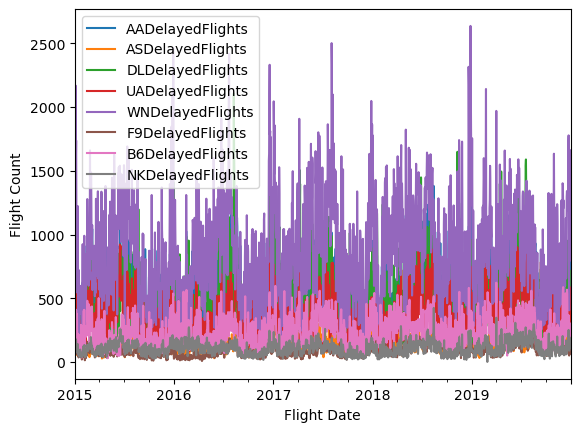

In [81]:
qstr = '''
select FlightDate, count(*) as TotalFlights,
count(case when (DepDel15==1 or ArrDel15==1) and Reporting_Airline in ('AA','US') then Year end) as AADelayedFlights,
count(case when (DepDel15==1 or ArrDel15==1) and Reporting_Airline in ('AS','VX') then Year end) as ASDelayedFlights,
count(case when (DepDel15==1 or ArrDel15==1) and Reporting_Airline=='DL' then Year end) as DLDelayedFlights,
count(case when (DepDel15==1 or ArrDel15==1) and Reporting_Airline=='UA' then Year end) as UADelayedFlights,
count(case when (DepDel15==1 or ArrDel15==1) and Reporting_Airline=='WN' then Year end) as WNDelayedFlights,
count(case when (DepDel15==1 or ArrDel15==1) and Reporting_Airline=='F9' then Year end) as F9DelayedFlights,
count(case when (DepDel15==1 or ArrDel15==1) and Reporting_Airline=='B6' then Year end) as B6DelayedFlights,
count(case when (DepDel15==1 or ArrDel15==1) and Reporting_Airline=='NK' then Year end) as NKDelayedFlights
from 'bts_faa_coords.parquet'
where Reporting_Airline in ('AA','AS','B6','DL','EV','F9','HA','NK','OO','UA','US','VX','WN')
group by FlightDate
order by FlightDate
'''

dfa = duckdb.query(qstr).df()
dfa.FlightDate = pd.to_datetime(dfa.FlightDate)
dfa = dfa.set_index('FlightDate')
dfa = dfa[:'2019-12-31']

# test = df.DelayedFlights['2023-01-01':]
# preds = model.forecast(steps=365+366+365+365+test.shape[0])

dfa.plot(y=['AADelayedFlights', 'ASDelayedFlights','DLDelayedFlights', 'UADelayedFlights', 'WNDelayedFlights',
            'F9DelayedFlights', 'B6DelayedFlights', 'NKDelayedFlights'],
        xlabel="Flight Date", ylabel="Flight Count")

In [82]:
# Create date features
dfa['date'] = dfa.index
dfa['dayofweek'] = dfa['date'].dt.dayofweek
dfa['quarter'] = dfa['date'].dt.quarter
dfa['month'] = dfa['date'].dt.month
dfa['year'] = dfa['date'].dt.year
dfa['dayofyear'] = dfa['date'].dt.dayofyear
dfa['dayofmonth'] = dfa['date'].dt.day

In [83]:
def xgcv_metrics(data, airline="AA", h=91, step=182, window_size=365):
    cv_mae_list = []
    cv_smape_list = []
    cv_rmse_list = []
    folds = 0
    exog_cols = ['dayofweek','quarter','month','year','dayofyear','dayofmonth']
    delay_col = airline + "DelayedFlights"
    cv = SlidingWindowForecastCV(h=91, step=182, window_size=365)
    X = data[exog_cols]
    y = data[delay_col]
    for item in cv.split(y):
        y_train = y[item[0]]
        y_test = y[item[1]]
        X_train = X.iloc[item[0],:]
        X_test = X.iloc[item[1],:]
        model = xgb.XGBRegressor(n_estimators=1000,
                                 early_stopping_rounds=50,
                                gamma=0, learning_rate=0.3,
                                max_depth=8, min_child_weight=1,
                                subsample=0.75, colsample_bylevel=0.75,
                                colsample_bynode=0.75, 
                                 colsample_bytree=0.75).fit(X_train, y_train,
                                                               eval_set=[(X_train, y_train), (X_test, y_test)],
                                                               verbose=False)
        preds = pd.Series(model.predict(X_test), index=X_test.index)    
        item_mae = mean_absolute_error(y_test, preds)
        cv_mae_list.append(item_mae)
        item_smape = smape(y_test, preds)
        cv_smape_list.append(item_smape)
        item_rmse = np.sqrt(mean_squared_error(y_test, preds))
        cv_rmse_list.append(item_rmse)
        folds +=1

    cv_mae = round(np.array(cv_mae_list).mean(),1), round(np.array(cv_mae_list).std(),1)
    cv_smape = round(np.array(cv_smape_list).mean(),1), round(np.array(cv_smape_list).std(),1)
    cv_rmse = round(np.array(cv_rmse_list).mean(),1), round(np.array(cv_rmse_list).std(),1)
            
    return folds, cv_mae, cv_smape, cv_rmse

In [84]:
for airline in ('AA', 'AS', 'DL', 'UA', 'WN', 'F9', 'B6', 'NK'):
    folds, cv_mae, cv_smape, cv_rmse = xgcv_metrics(dfa, airline)
    print(f"{airline}: MAE={cv_mae[0]}, SMAPE={cv_smape[0]}%, RMSE={cv_rmse[0]}, Change in SMAPE={round(cv_smape[0]-23.7,1)}%")

AA: MAE=161.3, SMAPE=28.5%, RMSE=205.9, Change in SMAPE=4.8%
AS: MAE=45.0, SMAPE=32.3%, RMSE=59.8, Change in SMAPE=8.6%
DL: MAE=179.8, SMAPE=38.7%, RMSE=248.8, Change in SMAPE=15.0%
UA: MAE=113.8, SMAPE=33.2%, RMSE=145.8, Change in SMAPE=9.5%
WN: MAE=242.0, SMAPE=29.8%, RMSE=314.9, Change in SMAPE=6.1%
F9: MAE=32.5, SMAPE=39.1%, RMSE=41.1, Change in SMAPE=15.4%
B6: MAE=85.1, SMAPE=35.4%, RMSE=107.9, Change in SMAPE=11.7%
NK: MAE=37.0, SMAPE=36.3%, RMSE=48.2, Change in SMAPE=12.6%


We found that errors (based on SMAPE) for each airline increased by 4.8-15.4%. The best performing of the four airlines was American while the worst was Frontier. There is no obvious reason other than the fact that we are using far less training data for individual airlines than we were for all reporting airlines.